In [2]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
np.random.seed(1234)

# SGD Isotropic Gaussian Neural Net

I implemented a single layer neural network and trained in on jointly Bernoulli and isotropic Gaussian data constructed in the 2018 paper by Mei et al. entitled 'A mean field view of the landscape of two-layerneural networks' using stochastic gradient descent. I studied limiting properties of the evolution of the network parameters, treated as interacting particles and made comparisons in monitoring losses incurred by the discretised SGD algorithm and the distributional dynamics introduced in the paper.

In [3]:
#Ground truth data distribution
def random_sample_old(d, Delta, N):
    """
    Generate random data samples for a binary classification problem.

    Parameters:
    d (int): The dimensionality of the data samples.
    Delta (float): The parameter controlling the spread of data samples (default is 0.1).
    N (int): The number of data samples to generate.

    Returns:
    tuple: A tuple containing a numpy array of data samples with shape (N, d) and labels with shape (N,).
    """
    y = np.random.randint(0,2,N)
    y = np.where(y==0, -1, y)
    x = np.zeros((N,d))
    for i in range(N):
        if y[i] == 1:
            x[i,:] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*d))
        if y[i] == -1:
            x[i,:] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*d))
    return x.reshape(N,d),y

In [4]:
#Ground truth data distribution
def random_sample(d, Delta, N):
    """
    Generate random data samples for a binary classification problem.

    Parameters:
    d (int): The dimensionality of the data samples.
    Delta (float): The parameter controlling the spread of data samples (default is 0.1).
    N (int): The number of data samples to generate.

    Returns:
    tuple: A tuple containing a numpy array of data samples with shape (N, d) and labels with shape (N,).
    """
    y = np.ones(N)
    x = np.zeros((N,d))
    successes = np.random.binomial(N, 0.5)
    y[successes:] *= -1
    x[:successes, :] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*d), successes)
    x[successes:, :] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*d), N-successes)
    
    return x.reshape(N,d),y

In [5]:
#activation function
def sigma(t, t1, s1, t2, s2):
    """
    Piecewise linear activation function with specified parameters.

    Parameters:
    t (float): Input value.
    t1 (float): Threshold value 1.
    s1 (float): Output value when t < t1.
    t2 (float): Threshold value 2.
    s2 (float): Output value when t > t2.

    Returns:
    float: The output of the piecewise linear activation function.
    """

    if t < t1:
        return s1
    elif t>t2:
        return s2
    else:
        return (s2-s1)/(t2-t1)*(t-t1)+s1
    
def grad_sigma(t, t1, s1, t2, s2):
    """
    Compute the gradient of the piecewise linear activation function with specified parameters.

    Parameters:
    t (float): Input value.
    t1 (float): Threshold value 1.
    s1 (float): Output value when t < t1.
    t2 (float): Threshold value 2.
    s2 (float): Output value when t > t2.

    Returns:
    float: The gradient of the piecewise linear activation function.
    """
    if t < t1:
        return 0
    elif t>t2:
        return 0
    else:
        return (s2-s1)/(t2-t1)
    
vgrad_sigma = np.vectorize(grad_sigma)
vsigma = np.vectorize(sigma)

In [6]:
#two layer neural net
def neural_net(x, θ):
    """
    Compute the output of a two-layer neural network.

    Parameters:
    x (np.ndarray): Input data with shape (n, d).
    θ (np.ndarray): Model parameters with shape (N, d), where N is the number of units in the hidden layer.

    Returns:
    np.ndarray: The output of the two-layer neural network with shape (n, 1).
    """
    n = x.shape[0]
    out = vsigma(θ@x.T, 0.5, -2.5, 1.5, 7.5)
    return np.mean(out, axis = 0).reshape(n,1)

In [7]:
def stochastic_gradient_descent(d, Delta, N, epsilon = 1e-6, num_epochs = 1000):
    """
    Perform stochastic gradient descent (SGD) training on a neural network with specified parameters.

    Parameters:
    d (int): The dimensionality of the data samples.
    Delta (float): The parameter controlling the spread of data samples.
    N (int): The number of units in the hidden layer.
    epsilon (float): The learning rate for SGD (default is 1e-6).
    num_epochs (int): The number of training epochs (default is 1000).

    Returns:
    tuple: A tuple containing the trained weights 'weights', an array of population risk values during training, 
           and an array of mean distances between weights and units during training.
    """
    indices = [int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 60))]
    weights = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), N).reshape(N, d)
    risk = []
    mean_dist = []

    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        sample = random_sample(d,Delta,1)
        X = sample[0].reshape(1,d)
        y = sample[1]
        vgrad = vgrad_sigma(weights@X.T, 0.5, -2.5, 1.5, 7.5)
        gradient = vgrad.reshape(N,1)*(X).reshape(1,d)
        weights += 2*epsilon*(y-neural_net(X, weights))*gradient
        if epoch in indices:
        #population risk
            M = int(5e3)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample.reshape(-1,1)-neural_net(x_sample,weights))**2)
            risk.append(mse)
            dist = np.mean(np.linalg.norm(weights, axis = 1))
            mean_dist.append(dist)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
        
    return weights, risk, mean_dist

In [8]:
def nesterov_accelerated_sgd(d, Delta, N, epsilon = 1e-6, r = 3, num_epochs = 1000):
    """
    Perform Nesterov Accelerated Stochastic Gradient Descent (Nesterov SGD) training on a neural network with specified parameters.

    Parameters:
    d (int): The dimensionality of the data samples.
    Delta (float): The parameter controlling the spread of data samples.
    N (int): The number of units in the hidden layer.
    epsilon (float): The learning rate for Nesterov SGD (default is 1e-6).
    r (int): The lookahead parameter for Nesterov acceleration (default is 3).
    num_epochs (int): The number of training epochs (default is 1000).

    Returns:
    tuple: A tuple containing the trained weights 'weights', lookahead weights 'lookahead', 
           an array of population risk values during training, and an empty array for mean distances.
    """
    indices = [int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 60))]
    weights = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), N).reshape(N, d)
    lookahead = weights
    risk = []
    mean_dist = []

    for epoch in trange(1, num_epochs+1): 
        # Update the params 
        sample = random_sample(d,Delta,1)
        X = sample[0].reshape(1,d)
        y = sample[1]
        
        vgrad = vgrad_sigma(lookahead@X.T, 0.5, -2.5, 1.5, 7.5)
        gradient = vgrad.reshape(N,1)*(X).reshape(1,d)
        
        weights_new = lookahead + 2*epsilon*(y-neural_net(X, lookahead))*gradient
        lookahead = weights_new + 0.9*(weights_new - weights)
        #((epoch-1)/(epoch+r-1))
        weights = weights_new
        
        if epoch in indices:
        #population risk
            M = int(5e3)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample.reshape(-1,1)-neural_net(x_sample, weights))**2)
            risk.append(mse)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
        
    return weights, lookahead, risk, mean_dist

In [9]:
def nesterov_heat_sgd(d, Delta, N, epsilon = 1e-6, r = 3, num_epochs = 1000):
    """
    Perform Nesterov Accelerated Stochastic Gradient Descent (Nesterov SGD) with added heat noise during training 
    on a neural network with specified parameters.

    Parameters:
    d (int): The dimensionality of the data samples.
    Delta (float): The parameter controlling the spread of data samples.
    N (int): The number of units in the hidden layer.
    epsilon (float): The learning rate for Nesterov SGD (default is 1e-6).
    r (int): The lookahead parameter for Nesterov acceleration (default is 3).
    num_epochs (int): The number of training epochs (default is 1000).

    Returns:
    tuple: A tuple containing the trained weights 'weights', lookahead weights 'lookahead', 
           an array of population risk values during training, and an array of mean distances between weights and units during training.
    """
    indices = [int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 60))]
    weights = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), N).reshape(N, d)
    lookahead = weights
    risk = []
    mean_dist = []

    for epoch in trange(1, num_epochs+1): 
        # Update the params 
        sample = random_sample(d,Delta,1)
        X = sample[0].reshape(1,d)
        y = sample[1]
        
        heat_loss = np.random.normal(0,1,lookahead.shape)
        lookahead += heat_loss
        
        vgrad = vgrad_sigma(lookahead@X.T, 0.5, -2.5, 1.5, 7.5)
        gradient = vgrad.reshape(N,1)*(X).reshape(1,d)
        
        weights_new = lookahead + 2*epsilon*(y-neural_net(X, lookahead))*gradient
        lookahead = weights_new + 0.9*(weights_new - weights)
        #((epoch-1)/(epoch+r-1))
        weights = weights_new
        
        if epoch in indices:
        #population risk
            M = int(5e3)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample.reshape(-1,1)-neural_net(x_sample,weights))**2)
            risk.append(mse)
            dist = np.mean(np.linalg.norm(weights, axis = 1))
            mean_dist.append(dist)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
        
    return weights, lookahead, risk, mean_dist

In [30]:
def Mass(d,Delta, N, epsilon = 1e-5, num_epochs = 1000):
    """
    Train a neural network with a specified number of units (N) using Momentum-added Stochastic Solver (Mass).


    Parameters:
    d (int): The dimensionality of the data samples.
    Delta (float): The parameter controlling the spread of data samples.
    N (int): The number of units in the hidden layer.
    epsilon (float): The learning rate for Mass (default is 1e-5).
    num_epochs (int): The number of training epochs (default is 1000).

    Returns:
    tuple: A tuple containing the trained weights 'weights' and an array of population risk values during training.
    """
    
    indices = [int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 60))]
    weights = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), N).reshape(N, d)
    lookahead = weights
    
    risk = []
    count = 1

    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample(d,Delta,1)
        x = x.reshape(1,d)
        
        lr = epsilon
        
        vgrad = vgrad_sigma(lookahead@x.T, 0.5, -2.5, 1.5, 7.5)
        gradient = vgrad.reshape(N,1)*(x).reshape(1,d)
        
        eta2 = lr/10
        weights_new = lookahead + 2*lr*(y-neural_net(x, lookahead))*gradient
        lookahead = weights_new + ((count-1)/(count+2))*(weights_new - weights) - \
        eta2*2*(y-neural_net(x, lookahead))*gradient
        #((epoch-1)/(epoch+r-1)), r>=3
            
        if np.sum((weights_new-weights)*(y-neural_net(x, lookahead))*gradient) < 0:
                count = 1
        count += 1

        weights = weights_new
        
        if epoch in indices:
        #population risk
            M = int(5e3)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample.reshape(-1,1)-neural_net(x_sample,weights))**2)
            risk.append(mse)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
                
    return weights, np.array(risk)

In [16]:
#params
d = 40
N = 80
Delta = 0.8

weights, risk_SGD, mean_dist_SGD = stochastic_gradient_descent(d, Delta, N, epsilon = 1e-6, num_epochs = int(1e6))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Epoch: 12, risk: 1.76826380759239
Epoch: 15, risk: 1.7998085096383762
Epoch: 18, risk: 1.7802751350743335
Epoch: 22, risk: 1.7933186411174924
Epoch: 27, risk: 1.782314374260037
Epoch: 32, risk: 1.7745120082603163
Epoch: 39, risk: 1.8102338840487247
Epoch: 48, risk: 1.791164813165378
Epoch: 58, risk: 1.7689128430420837
Epoch: 70, risk: 1.7672875098928866
Epoch: 85, risk: 1.8052285366481562
Epoch: 103, risk: 1.7757807150502392
Epoch: 124, risk: 1.7719380504553162
Epoch: 151, risk: 1.7841281940564502
Epoch: 183, risk: 1.777155768555916
Epoch: 221, risk: 1.812479752458696
Epoch: 268, risk: 1.7673767943930256
Epoch: 324, risk: 1.7750419636415966
Epoch: 393, risk: 1.786040913940937
Epoch: 476, risk: 1.7566501174474731
Epoch: 576, risk: 1.7743913595399368
Epoch: 698, risk: 1.7799648407279354
Epoch: 845, risk: 1.7838301149366307
Epoch: 1023, risk: 1.7907595067308182
Epoch: 1239, risk: 1.7667379718361127
Epoch: 1500, risk: 1.7673248135059192
Epoch: 1816, risk: 1.7483558957857996
Epoch: 2199, ri

In [31]:
#simulate Momentum-added Stochastic Solver (Mass) sgd
#params
d = 40
N = 80
Delta = 0.8

weights, risk_Mass =\
Mass(d, Delta, N, epsilon = (1e-6), num_epochs = int(1e6))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Epoch: 12, risk: 1.7695657896518904
Epoch: 15, risk: 1.7768271952109103
Epoch: 18, risk: 1.7870177177781046
Epoch: 22, risk: 1.7746615804035668
Epoch: 27, risk: 1.7797677887196115
Epoch: 32, risk: 1.7920905070701847
Epoch: 39, risk: 1.780789135119954
Epoch: 48, risk: 1.7679211354350932
Epoch: 58, risk: 1.7766611025054877
Epoch: 70, risk: 1.7907363210071674
Epoch: 85, risk: 1.751183897511683
Epoch: 103, risk: 1.788486083276174
Epoch: 124, risk: 1.781374918335196
Epoch: 151, risk: 1.759337668727705
Epoch: 183, risk: 1.7367528076852417
Epoch: 221, risk: 1.7160777795243076
Epoch: 268, risk: 1.7057888081861805
Epoch: 324, risk: 1.6759219563327177
Epoch: 393, risk: 1.6067156595458212
Epoch: 476, risk: 1.5955856792345506
Epoch: 576, risk: 1.5752750515164102
Epoch: 698, risk: 1.5499744027482345
Epoch: 845, risk: 1.4920642476424522
Epoch: 1023, risk: 1.5038048407825746
Epoch: 1239, risk: 1.4842058253377903
Epoch: 1500, risk: 1.4356725669595403
Epoch: 1816, risk: 1.4528064523708213
Epoch: 2199, 

In [28]:
#params
d = 40
N = 80
Delta = 0.8

weights_NSGD, momentum_NSGD, risk_NSGD, mean_dist_NSGD = nesterov_accelerated_sgd(d, Delta, N, epsilon = 1e-6, r = 3, num_epochs = int(1e6))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Epoch: 12, risk: 1.7515802701833803
Epoch: 15, risk: 1.784177888491935
Epoch: 18, risk: 1.799387638493256
Epoch: 22, risk: 1.784474588157701
Epoch: 27, risk: 1.7836881446580588
Epoch: 32, risk: 1.7621273482925288
Epoch: 39, risk: 1.7916413744409307
Epoch: 48, risk: 1.7556664280856942
Epoch: 58, risk: 1.7651910782855387
Epoch: 70, risk: 1.7594477211324386
Epoch: 85, risk: 1.758397430230727
Epoch: 103, risk: 1.7764672181603407
Epoch: 124, risk: 1.799889544328388
Epoch: 151, risk: 1.772871054127757
Epoch: 183, risk: 1.754425135383885
Epoch: 221, risk: 1.7559308895845847
Epoch: 268, risk: 1.7693875038147209
Epoch: 324, risk: 1.7696905752406695
Epoch: 393, risk: 1.7612747530259065
Epoch: 476, risk: 1.7528702469610613
Epoch: 576, risk: 1.7329118003271018
Epoch: 698, risk: 1.7136953548186138
Epoch: 845, risk: 1.708623809257225
Epoch: 1023, risk: 1.7188684841756392
Epoch: 1239, risk: 1.7070833829277479
Epoch: 1500, risk: 1.7024811513077038
Epoch: 1816, risk: 1.6619503836447185
Epoch: 2199, ris

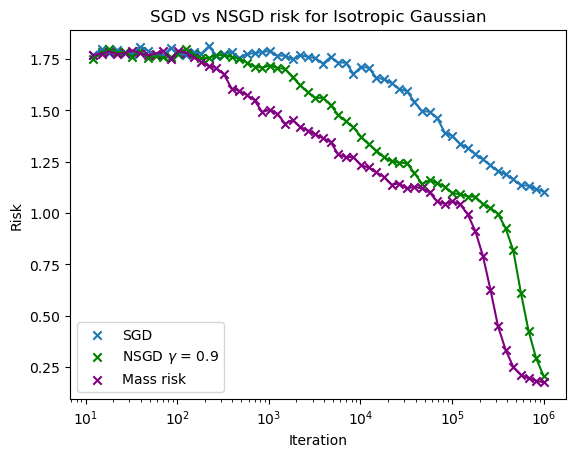

In [32]:
#plot SGD and Nesterov SGD losses
indices = np.array([int(a) for a in 10**(np.linspace(1.1, np.log10(1e6), 60))])
indices_Mass = np.array([int(a) for a in 10**(np.linspace(1.1, np.log10(1e6), 60))])
plt.plot(indices, risk_SGD)
plt.scatter(indices, risk_SGD, marker = 'x', label = 'SGD')
plt.plot(indices, risk_NSGD, c = 'g')
plt.scatter(indices, risk_NSGD, marker = 'x', label = 'NSGD $\gamma$ = 0.9', c = 'g')
plt.plot(indices_Mass, risk_Mass, c = 'purple')
plt.scatter(indices_Mass, risk_Mass, marker = 'x', c = 'purple', label = 'Mass risk')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Risk')
plt.legend()
plt.title('SGD vs NSGD risk for Isotropic Gaussian')
plt.savefig("/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/Nguyen2018-SGD-algos-risk-iso-gauss.png")

In [21]:
from scipy.stats import norm

def q_plus(t, Delta):
    x = np.linspace(0.5/((1+Delta)*t), 1.5/((1+Delta)*t), 100)
    f = 1 / (np.sqrt(2 * np.pi)) * vsigma((1 + Delta) * t * x, 0.5, -2.5, 1.5, 7.5) * np.exp(-x ** 2 / 2)
    integral = np.trapz(f, x)
    return integral -2.5*norm.cdf(0.5/((1+Delta)*t))+7.5*(1-norm.cdf(1.5/((1+Delta)*t)))
    #return integral

def q_minus(t, Delta):
    x = np.linspace(0.5/((1-Delta)*t), 1.5/((1-Delta)*t), 100)
    f = 1 / (np.sqrt(2 * np.pi)) * vsigma((1 - Delta) * t * x, 0.5, -2.5, 1.5, 7.5) * np.exp(-x ** 2 / 2)
    integral = np.trapz(f, x)
    return integral -2.5*norm.cdf(0.5/((1-Delta)*t))+7.5*(1-norm.cdf(1.5/((1-Delta)*t)))
    #return integral

vq_plus = np.vectorize(q_plus)
vq_minus = np.vectorize(q_minus)

def dq_plus(t, Delta):
    x = np.linspace(0.5/((1+Delta)*t), 1.5/((1+Delta)*t), 100)
    f = (1+Delta) / (np.sqrt(2 * np.pi)) * 10 * np.exp(-x ** 2 / 2)*x
    integral = np.trapz(f, x)
    return integral 

def dq_minus(t, Delta):
    x = np.linspace(0.5/((1-Delta)*t), 1.5/((1-Delta)*t), 100)
    f = (1-Delta) / (np.sqrt(2 * np.pi)) * 10 * np.exp(-x ** 2 / 2)*x
    integral = np.trapz(f, x)
    return integral
    
vdq_plus = np.vectorize(dq_plus)
vdq_minus = np.vectorize(dq_minus)

def q_func(pair):
    t = pair[0]
    flag = pair[1]
    if flag == 0:
        return vq_plus(t,0.8)
    elif flag == 1:
        return vq_minus(t,0.8)
    elif flag == 2:
        return vdq_plus(t,0.8)
    elif flag == 3:
        return vdq_minus(t,0.8)
    
def q_func_new(pair):
    t = pair[0]
    flag = pair[1]
    if flag == 0:
        return vq_plus_new(t)
    elif flag == 1:
        return vq_minus_new(t)
    elif flag == 2:
        return vdq_plus_new(t)
    elif flag == 3:
        return vdq_minus_new(t)

def parallelise(t):
    with Pool(4) as p:
        results = np.array(p.map(q_func_new, [[t,0], [t,1], [t,2], [t,3]]))
    return results
vparallelise = np.vectorize(parallelise)

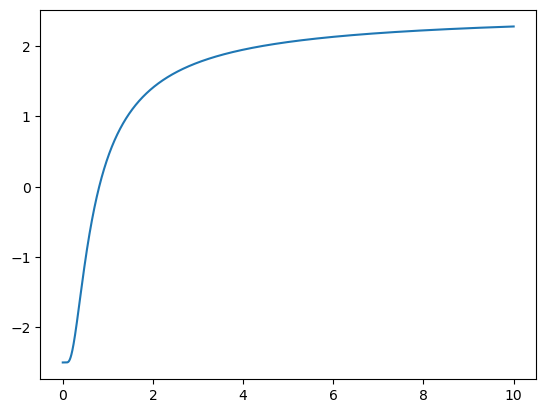

In [22]:
epsilon = 1e-6
Delta = 0.8
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_plus_vals = vq_plus(Interval_q, Delta)
plt.plot(Interval_q, q_plus_vals)

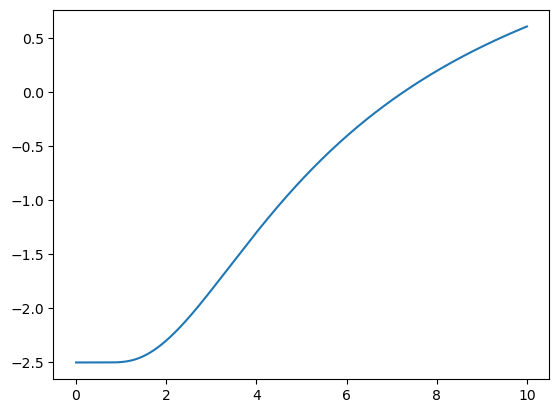

In [23]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_minus_vals = vq_minus(Interval_q, Delta)
plt.plot(Interval_q, q_minus_vals)

In [24]:
Q_plus = dict(zip(Interval_q, q_plus_vals))
Q_minus = dict(zip(Interval_q, q_minus_vals))

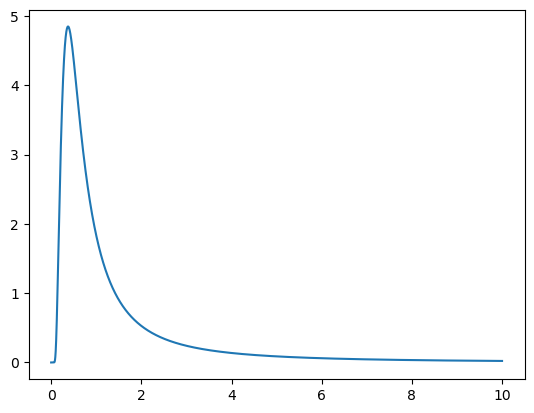

In [25]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_plus_vals = vdq_plus(Interval_q, Delta)
plt.plot(Interval_q, dq_plus_vals)

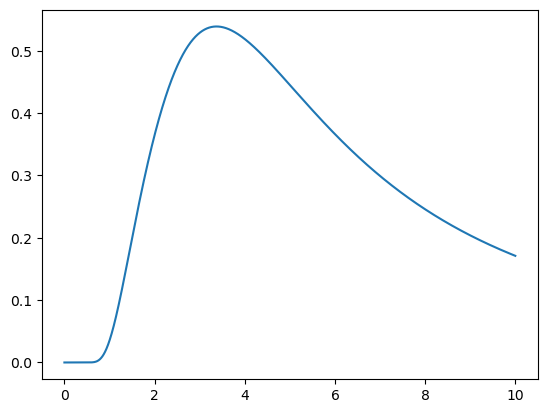

In [26]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_minus_vals = vdq_minus(Interval_q, Delta)
plt.plot(Interval_q, dq_minus_vals)

In [27]:
dQ_plus = dict(zip(Interval_q, dq_plus_vals))
dQ_minus = dict(zip(Interval_q, dq_minus_vals))

In [28]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
vfind_nearest = np.vectorize(find_nearest)

In [29]:
def q_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_plus[r_approx]

def q_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_minus[r_approx]

vq_plus_new = np.vectorize(q_plus_new)
vq_minus_new = np.vectorize(q_minus_new)

def dq_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_plus[r_approx]

def dq_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_minus[r_approx]

vdq_plus_new = np.vectorize(dq_plus_new)
vdq_minus_new = np.vectorize(dq_minus_new)


def R_inf(vq_plus, vq_minus, Delta):
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return 0.5 * (1 - mean_vq_plus) ** 2 + 0.5 * (1 + mean_vq_minus) ** 2

def grad_R_inf(r, vq_plus, vq_minus, dplus, dminus, Delta):
    J = len(r)
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return -1 / J * dplus * (1 - mean_vq_plus) + 1 / J * dminus * (1 + mean_vq_minus)

def update(r, dt, grad):
    J = len(r)
    return J * grad * dt

In [95]:
#simulate pde
epsilon = 1e-6
Interval = 10**np.linspace(-7,np.log10(epsilon*1e7), int(1e3))
J = 1
Iters = 10
pde_vals = np.zeros((Iters,J))
Delta = 0.8
d = 40
separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]

In [96]:
#simulate 100 times and obtain a histogram
processes_count = 1
for i in trange(Iters):
    Z = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), J).reshape(J, d)
    r = np.linalg.norm(Z, axis = 1)
    for dt in tqdm(separations):
        ''''
        plus = vq_plus(r, Delta)
        minus = vq_minus(r, Delta)
        dplus = vdq_plus(r, Delta)
        dminus = vdq_minus(r, Delta)
        '''
        output = parallelise(r).reshape(4,J)
        plus = output[0]
        minus = output[1]
        dplus = output[2]
        dminus = output[3]
        
        grad = grad_R_inf(r, plus, minus, dplus, dminus, Delta)
        r = r - update(r,dt, grad)
    pde_vals[i] = r

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [72]:
pde_vals

array([[ 4.31988202,  3.55852702,  3.45414668,  2.97535378],
       [ 1.13494949,  4.46306836,  4.45301163,  3.10193067],
       [ 4.98971929,  0.83375498,  1.87039796,  4.45738908],
       [ 4.01347409,  4.58249049,  4.72574147, -0.27869426],
       [ 4.29682542,  3.60694377, -0.46161056,  4.60593769],
       [ 2.65207937,  2.91469589,  4.03683624,  4.43495605],
       [ 4.19816753,  4.93449979,  4.50670496, -0.19744513],
       [ 0.03379664,  4.72920349,  4.67350447,  4.54784509],
       [ 3.15379725,  3.90596194,  3.17888985,  4.10399091],
       [ 4.40132767,  3.61348877,  5.06242229, -0.34742211]])

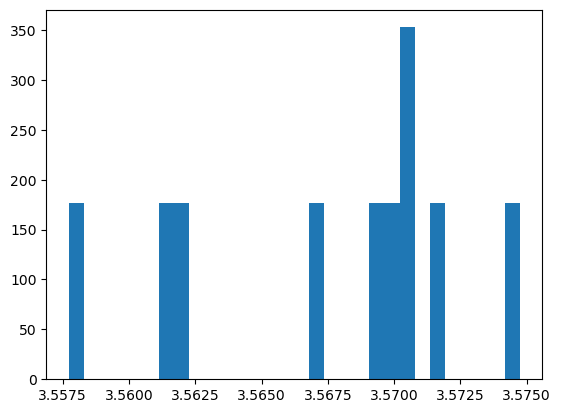

In [93]:
import matplotlib.pyplot as plt
y = np.ndarray.flatten(pde_vals)
(n, bins, patches) = plt.hist(y, density = True, bins = 30)

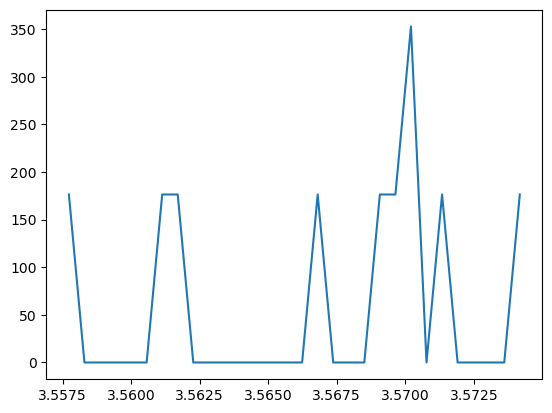

In [94]:
plt.plot(bins[:-1], n)

In [23]:
Z = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), J).reshape(J, d)
r = np.linalg.norm(Z, axis = 1)
start = time.time()
plus = vq_plus_new(r)
minus = vq_minus_new(r)
dplus = vdq_plus_new(r)
dminus = vdq_minus_new(r)
print('Elapsed time: {}'.format(time.time()-start))

Elapsed time: 0.2292160987854004


In [24]:
Z = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), J).reshape(J, d)
r = np.linalg.norm(Z, axis = 1)
start = time.time()
output = parallelise(r).reshape(4,J)
plus = output[0]
minus = output[1]
dplus = output[2]
dminus = output[3]
print('Elapsed time: {}'.format(time.time()-start))

Elapsed time: 0.15790319442749023


## Simulate PDE risk

In [31]:
#simulate pde risk
def pde_sim(d, J, epsilon = 1e-6, Delta = 0.8):
    """
    Simulate the risk evolution of a Partial Differential Equation (PDE) system.

    Parameters:
    d (int): The dimensionality of the system.
    J (int): The number of units in the system.
    epsilon (float): The time step for simulation (default is 1e-6).
    Delta (float): The parameter controlling the spread of data samples (default is 0.8).

    Returns:
    tuple: A tuple containing an array of risk values during the simulation and an array of mean distances.
    """
    Interval = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e4))
    separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]
    processes_count = 4
    risk = np.zeros(Interval.shape[0])
    Z = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), J).reshape(J, d)
    r = np.linalg.norm(Z, axis = 1)
    mean_dist = []
    for k in trange(len(separations)):
        dt = separations[k]
        plus = vq_plus(r, Delta)
        minus = vq_minus(r, Delta)
        dplus = vdq_plus(r, Delta)
        dminus = vdq_minus(r, Delta)
        
        inf_risk = R_inf(plus, minus, Delta)
        risk[k] = inf_risk
        d = np.mean(r)
        mean_dist.append(d)
        print('Epoch: {}, dist: {}'.format(k, inf_risk))
        grad = grad_R_inf(r, plus, minus, dplus, dminus, Delta)
        r = r - update(r,dt, grad)
    plus = vq_plus(r, Delta)
    minus = vq_minus(r, Delta)
    inf_risk = R_inf(plus, minus, Delta)
    risk[-1] = inf_risk
    mean_dist.append(np.mean(r))
    return risk, mean_dist

In [32]:
d = 40
J = 400
risk_pde, mean_dist_pde = pde_sim(d, J, epsilon = 1e-6, Delta = 0.8)

  0%|          | 0/9999 [00:00<?, ?it/s]

Epoch: 0, dist: 1.6726417580001458
Epoch: 1, dist: 1.6726417579981463
Epoch: 2, dist: 1.6726417579961406
Epoch: 3, dist: 1.6726417579941302
Epoch: 4, dist: 1.672641757992115
Epoch: 5, dist: 1.672641757990095
Epoch: 6, dist: 1.6726417579880688
Epoch: 7, dist: 1.672641757986038
Epoch: 8, dist: 1.6726417579840023
Epoch: 9, dist: 1.6726417579819615
Epoch: 10, dist: 1.6726417579799155
Epoch: 11, dist: 1.6726417579778636
Epoch: 12, dist: 1.6726417579758073
Epoch: 13, dist: 1.6726417579737456
Epoch: 14, dist: 1.6726417579716788
Epoch: 15, dist: 1.672641757969606
Epoch: 16, dist: 1.6726417579675283
Epoch: 17, dist: 1.6726417579654453
Epoch: 18, dist: 1.6726417579633575
Epoch: 19, dist: 1.6726417579612645
Epoch: 20, dist: 1.6726417579591653
Epoch: 21, dist: 1.6726417579570625
Epoch: 22, dist: 1.6726417579549522
Epoch: 23, dist: 1.672641757952837
Epoch: 24, dist: 1.6726417579507173
Epoch: 25, dist: 1.6726417579485922
Epoch: 26, dist: 1.6726417579464612
Epoch: 27, dist: 1.6726417579443247
Epoch: 

Epoch: 226, dist: 1.6726417573908439
Epoch: 227, dist: 1.6726417573872987
Epoch: 228, dist: 1.672641757383744
Epoch: 229, dist: 1.6726417573801808
Epoch: 230, dist: 1.672641757376608
Epoch: 231, dist: 1.6726417573730261
Epoch: 232, dist: 1.6726417573694357
Epoch: 233, dist: 1.6726417573658363
Epoch: 234, dist: 1.6726417573622274
Epoch: 235, dist: 1.6726417573586092
Epoch: 236, dist: 1.6726417573549823
Epoch: 237, dist: 1.6726417573513452
Epoch: 238, dist: 1.6726417573476997
Epoch: 239, dist: 1.6726417573440446
Epoch: 240, dist: 1.6726417573403813
Epoch: 241, dist: 1.6726417573367072
Epoch: 242, dist: 1.6726417573330243
Epoch: 243, dist: 1.6726417573293326
Epoch: 244, dist: 1.6726417573256311
Epoch: 245, dist: 1.6726417573219197
Epoch: 246, dist: 1.6726417573181998
Epoch: 247, dist: 1.6726417573144703
Epoch: 248, dist: 1.6726417573107306
Epoch: 249, dist: 1.6726417573069825
Epoch: 250, dist: 1.672641757303224
Epoch: 251, dist: 1.6726417572994565
Epoch: 252, dist: 1.672641757295679
Epoch

Epoch: 450, dist: 1.6726417563232818
Epoch: 451, dist: 1.6726417563170288
Epoch: 452, dist: 1.6726417563107598
Epoch: 453, dist: 1.672641756304475
Epoch: 454, dist: 1.6726417562981744
Epoch: 455, dist: 1.6726417562918576
Epoch: 456, dist: 1.6726417562855254
Epoch: 457, dist: 1.6726417562791753
Epoch: 458, dist: 1.6726417562728109
Epoch: 459, dist: 1.6726417562664295
Epoch: 460, dist: 1.6726417562600322
Epoch: 461, dist: 1.6726417562536187
Epoch: 462, dist: 1.672641756247189
Epoch: 463, dist: 1.6726417562407434
Epoch: 464, dist: 1.6726417562342804
Epoch: 465, dist: 1.6726417562278018
Epoch: 466, dist: 1.6726417562213067
Epoch: 467, dist: 1.6726417562147953
Epoch: 468, dist: 1.6726417562082667
Epoch: 469, dist: 1.6726417562017217
Epoch: 470, dist: 1.6726417561951603
Epoch: 471, dist: 1.672641756188582
Epoch: 472, dist: 1.6726417561819873
Epoch: 473, dist: 1.6726417561753752
Epoch: 474, dist: 1.6726417561687479
Epoch: 475, dist: 1.6726417561621023
Epoch: 476, dist: 1.6726417561554405
Epoc

Epoch: 673, dist: 1.672641754451425
Epoch: 674, dist: 1.6726417544404248
Epoch: 675, dist: 1.672641754429395
Epoch: 676, dist: 1.6726417544183387
Epoch: 677, dist: 1.6726417544072543
Epoch: 678, dist: 1.6726417543961416
Epoch: 679, dist: 1.6726417543850003
Epoch: 680, dist: 1.6726417543738314
Epoch: 681, dist: 1.6726417543626346
Epoch: 682, dist: 1.6726417543514083
Epoch: 683, dist: 1.672641754340154
Epoch: 684, dist: 1.67264175432887
Epoch: 685, dist: 1.6726417543175591
Epoch: 686, dist: 1.6726417543062189
Epoch: 687, dist: 1.6726417542948493
Epoch: 688, dist: 1.6726417542834522
Epoch: 689, dist: 1.672641754272025
Epoch: 690, dist: 1.6726417542605692
Epoch: 691, dist: 1.6726417542490846
Epoch: 692, dist: 1.6726417542375707
Epoch: 693, dist: 1.6726417542260275
Epoch: 694, dist: 1.672641754214455
Epoch: 695, dist: 1.672641754202854
Epoch: 696, dist: 1.672641754191222
Epoch: 697, dist: 1.6726417541795615
Epoch: 698, dist: 1.6726417541678713
Epoch: 699, dist: 1.6726417541561514
Epoch: 700

Epoch: 897, dist: 1.6726417511390304
Epoch: 898, dist: 1.6726417511196277
Epoch: 899, dist: 1.6726417511001765
Epoch: 900, dist: 1.6726417510806764
Epoch: 901, dist: 1.6726417510611256
Epoch: 902, dist: 1.6726417510415268
Epoch: 903, dist: 1.6726417510218776
Epoch: 904, dist: 1.6726417510021783
Epoch: 905, dist: 1.6726417509824292
Epoch: 906, dist: 1.6726417509626301
Epoch: 907, dist: 1.6726417509427804
Epoch: 908, dist: 1.6726417509228804
Epoch: 909, dist: 1.67264175090293
Epoch: 910, dist: 1.6726417508829305
Epoch: 911, dist: 1.672641750862879
Epoch: 912, dist: 1.672641750842776
Epoch: 913, dist: 1.672641750822622
Epoch: 914, dist: 1.6726417508024176
Epoch: 915, dist: 1.6726417507821623
Epoch: 916, dist: 1.672641750761855
Epoch: 917, dist: 1.6726417507414968
Epoch: 918, dist: 1.672641750721087
Epoch: 919, dist: 1.6726417507006248
Epoch: 920, dist: 1.67264175068011
Epoch: 921, dist: 1.6726417506595448
Epoch: 922, dist: 1.6726417506389262
Epoch: 923, dist: 1.672641750618256
Epoch: 924,

Epoch: 1119, dist: 1.6726417453651388
Epoch: 1120, dist: 1.6726417453310933
Epoch: 1121, dist: 1.67264174529696
Epoch: 1122, dist: 1.672641745262741
Epoch: 1123, dist: 1.672641745228435
Epoch: 1124, dist: 1.6726417451940412
Epoch: 1125, dist: 1.672641745159561
Epoch: 1126, dist: 1.6726417451249933
Epoch: 1127, dist: 1.6726417450903386
Epoch: 1128, dist: 1.672641745055595
Epoch: 1129, dist: 1.6726417450207631
Epoch: 1130, dist: 1.6726417449858437
Epoch: 1131, dist: 1.6726417449508348
Epoch: 1132, dist: 1.6726417449157385
Epoch: 1133, dist: 1.6726417448805515
Epoch: 1134, dist: 1.6726417448452757
Epoch: 1135, dist: 1.6726417448099113
Epoch: 1136, dist: 1.6726417447744573
Epoch: 1137, dist: 1.6726417447389128
Epoch: 1138, dist: 1.6726417447032784
Epoch: 1139, dist: 1.6726417446675528
Epoch: 1140, dist: 1.6726417446317376
Epoch: 1141, dist: 1.6726417445958306
Epoch: 1142, dist: 1.672641744559833
Epoch: 1143, dist: 1.672641744523744
Epoch: 1144, dist: 1.672641744487564
Epoch: 1145, dist: 1.

Epoch: 1338, dist: 1.672641735411517
Epoch: 1339, dist: 1.672641735352226
Epoch: 1340, dist: 1.6726417352927836
Epoch: 1341, dist: 1.6726417352331904
Epoch: 1342, dist: 1.6726417351734457
Epoch: 1343, dist: 1.672641735113551
Epoch: 1344, dist: 1.6726417350535028
Epoch: 1345, dist: 1.6726417349933032
Epoch: 1346, dist: 1.6726417349329508
Epoch: 1347, dist: 1.6726417348724456
Epoch: 1348, dist: 1.6726417348117861
Epoch: 1349, dist: 1.672641734750973
Epoch: 1350, dist: 1.6726417346900062
Epoch: 1351, dist: 1.6726417346288844
Epoch: 1352, dist: 1.672641734567608
Epoch: 1353, dist: 1.6726417345061755
Epoch: 1354, dist: 1.6726417344445879
Epoch: 1355, dist: 1.672641734382843
Epoch: 1356, dist: 1.6726417343209423
Epoch: 1357, dist: 1.6726417342588844
Epoch: 1358, dist: 1.6726417341966693
Epoch: 1359, dist: 1.6726417341342965
Epoch: 1360, dist: 1.6726417340717652
Epoch: 1361, dist: 1.6726417340090753
Epoch: 1362, dist: 1.672641733946227
Epoch: 1363, dist: 1.6726417338832182
Epoch: 1364, dist: 

Epoch: 1555, dist: 1.6726417182829916
Epoch: 1556, dist: 1.6726417181802573
Epoch: 1557, dist: 1.6726417180772608
Epoch: 1558, dist: 1.672641717974004
Epoch: 1559, dist: 1.6726417178704858
Epoch: 1560, dist: 1.6726417177667043
Epoch: 1561, dist: 1.67264171766266
Epoch: 1562, dist: 1.6726417175583514
Epoch: 1563, dist: 1.6726417174537787
Epoch: 1564, dist: 1.6726417173489403
Epoch: 1565, dist: 1.6726417172438364
Epoch: 1566, dist: 1.6726417171384664
Epoch: 1567, dist: 1.6726417170328276
Epoch: 1568, dist: 1.6726417169269223
Epoch: 1569, dist: 1.672641716820748
Epoch: 1570, dist: 1.672641716714304
Epoch: 1571, dist: 1.6726417166075898
Epoch: 1572, dist: 1.6726417165006064
Epoch: 1573, dist: 1.67264171639335
Epoch: 1574, dist: 1.6726417162858227
Epoch: 1575, dist: 1.672641716178022
Epoch: 1576, dist: 1.6726417160699485
Epoch: 1577, dist: 1.6726417159616012
Epoch: 1578, dist: 1.6726417158529778
Epoch: 1579, dist: 1.6726417157440787
Epoch: 1580, dist: 1.6726417156349052
Epoch: 1581, dist: 1

Epoch: 1773, dist: 1.6726416884263546
Epoch: 1774, dist: 1.6726416882478938
Epoch: 1775, dist: 1.672641688068981
Epoch: 1776, dist: 1.6726416878896138
Epoch: 1777, dist: 1.6726416877097918
Epoch: 1778, dist: 1.6726416875295138
Epoch: 1779, dist: 1.6726416873487782
Epoch: 1780, dist: 1.6726416871675849
Epoch: 1781, dist: 1.6726416869859317
Epoch: 1782, dist: 1.672641686803817
Epoch: 1783, dist: 1.6726416866212421
Epoch: 1784, dist: 1.6726416864382028
Epoch: 1785, dist: 1.6726416862546998
Epoch: 1786, dist: 1.6726416860707314
Epoch: 1787, dist: 1.6726416858862956
Epoch: 1788, dist: 1.6726416857013926
Epoch: 1789, dist: 1.6726416855160204
Epoch: 1790, dist: 1.6726416853301784
Epoch: 1791, dist: 1.6726416851438657
Epoch: 1792, dist: 1.6726416849570795
Epoch: 1793, dist: 1.6726416847698196
Epoch: 1794, dist: 1.6726416845820855
Epoch: 1795, dist: 1.6726416843938732
Epoch: 1796, dist: 1.6726416842051852
Epoch: 1797, dist: 1.672641684016019
Epoch: 1798, dist: 1.672641683826373
Epoch: 1799, dis

Epoch: 1992, dist: 1.6726416362524938
Epoch: 1993, dist: 1.6726416359417045
Epoch: 1994, dist: 1.672641635630126
Epoch: 1995, dist: 1.672641635317758
Epoch: 1996, dist: 1.6726416350045974
Epoch: 1997, dist: 1.6726416346906432
Epoch: 1998, dist: 1.6726416343758923
Epoch: 1999, dist: 1.6726416340603434
Epoch: 2000, dist: 1.6726416337439938
Epoch: 2001, dist: 1.6726416334268408
Epoch: 2002, dist: 1.6726416331088856
Epoch: 2003, dist: 1.6726416327901226
Epoch: 2004, dist: 1.672641632470551
Epoch: 2005, dist: 1.6726416321501696
Epoch: 2006, dist: 1.6726416318289754
Epoch: 2007, dist: 1.6726416315069663
Epoch: 2008, dist: 1.672641631184141
Epoch: 2009, dist: 1.6726416308604963
Epoch: 2010, dist: 1.6726416305360305
Epoch: 2011, dist: 1.6726416302107427
Epoch: 2012, dist: 1.67264162988463
Epoch: 2013, dist: 1.6726416295576896
Epoch: 2014, dist: 1.6726416292299193
Epoch: 2015, dist: 1.6726416289013182
Epoch: 2016, dist: 1.6726416285718835
Epoch: 2017, dist: 1.6726416282416143
Epoch: 2018, dist:

Epoch: 2209, dist: 1.6726415464699829
Epoch: 2210, dist: 1.672641545931477
Epoch: 2211, dist: 1.6726415453916055
Epoch: 2212, dist: 1.6726415448503653
Epoch: 2213, dist: 1.6726415443077518
Epoch: 2214, dist: 1.6726415437637625
Epoch: 2215, dist: 1.6726415432183932
Epoch: 2216, dist: 1.672641542671641
Epoch: 2217, dist: 1.6726415421235012
Epoch: 2218, dist: 1.672641541573972
Epoch: 2219, dist: 1.6726415410230484
Epoch: 2220, dist: 1.6726415404707278
Epoch: 2221, dist: 1.6726415399170067
Epoch: 2222, dist: 1.6726415393618803
Epoch: 2223, dist: 1.6726415388053466
Epoch: 2224, dist: 1.6726415382474016
Epoch: 2225, dist: 1.6726415376880408
Epoch: 2226, dist: 1.6726415371272614
Epoch: 2227, dist: 1.67264153656506
Epoch: 2228, dist: 1.672641536001433
Epoch: 2229, dist: 1.6726415354363757
Epoch: 2230, dist: 1.6726415348698849
Epoch: 2231, dist: 1.6726415343019585
Epoch: 2232, dist: 1.672641533732591
Epoch: 2233, dist: 1.6726415331617797
Epoch: 2234, dist: 1.6726415325895203
Epoch: 2235, dist: 

Epoch: 2426, dist: 1.6726413909037077
Epoch: 2427, dist: 1.672641389970639
Epoch: 2428, dist: 1.6726413890352032
Epoch: 2429, dist: 1.6726413880973947
Epoch: 2430, dist: 1.6726413871572077
Epoch: 2431, dist: 1.6726413862146365
Epoch: 2432, dist: 1.6726413852696744
Epoch: 2433, dist: 1.6726413843223153
Epoch: 2434, dist: 1.6726413833725544
Epoch: 2435, dist: 1.6726413824203834
Epoch: 2436, dist: 1.672641381465798
Epoch: 2437, dist: 1.672641380508792
Epoch: 2438, dist: 1.6726413795493578
Epoch: 2439, dist: 1.6726413785874903
Epoch: 2440, dist: 1.6726413776231834
Epoch: 2441, dist: 1.6726413766564308
Epoch: 2442, dist: 1.6726413756872271
Epoch: 2443, dist: 1.672641374715564
Epoch: 2444, dist: 1.6726413737414365
Epoch: 2445, dist: 1.672641372764839
Epoch: 2446, dist: 1.6726413717857638
Epoch: 2447, dist: 1.672641370804206
Epoch: 2448, dist: 1.6726413698201585
Epoch: 2449, dist: 1.672641368833615
Epoch: 2450, dist: 1.672641367844569
Epoch: 2451, dist: 1.672641366853015
Epoch: 2452, dist: 1.

Epoch: 2643, dist: 1.6726411213538925
Epoch: 2644, dist: 1.672641119737163
Epoch: 2645, dist: 1.672641118116333
Epoch: 2646, dist: 1.6726411164913921
Epoch: 2647, dist: 1.6726411148623295
Epoch: 2648, dist: 1.6726411132291357
Epoch: 2649, dist: 1.6726411115917994
Epoch: 2650, dist: 1.6726411099503107
Epoch: 2651, dist: 1.6726411083046584
Epoch: 2652, dist: 1.6726411066548321
Epoch: 2653, dist: 1.6726411050008214
Epoch: 2654, dist: 1.6726411033426163
Epoch: 2655, dist: 1.6726411016802043
Epoch: 2656, dist: 1.6726411000135766
Epoch: 2657, dist: 1.6726410983427211
Epoch: 2658, dist: 1.6726410966676286
Epoch: 2659, dist: 1.6726410949882875
Epoch: 2660, dist: 1.6726410933046871
Epoch: 2661, dist: 1.6726410916168157
Epoch: 2662, dist: 1.6726410899246646
Epoch: 2663, dist: 1.6726410882282212
Epoch: 2664, dist: 1.672641086527475
Epoch: 2665, dist: 1.672641084822415
Epoch: 2666, dist: 1.672641083113031
Epoch: 2667, dist: 1.672641081399311
Epoch: 2668, dist: 1.6726410796812445
Epoch: 2669, dist:

Epoch: 2861, dist: 1.672640651503619
Epoch: 2862, dist: 1.6726406486952081
Epoch: 2863, dist: 1.6726406458796736
Epoch: 2864, dist: 1.6726406430569982
Epoch: 2865, dist: 1.6726406402271645
Epoch: 2866, dist: 1.6726406373901526
Epoch: 2867, dist: 1.6726406345459457
Epoch: 2868, dist: 1.6726406316945244
Epoch: 2869, dist: 1.6726406288358717
Epoch: 2870, dist: 1.6726406259699682
Epoch: 2871, dist: 1.6726406230967967
Epoch: 2872, dist: 1.6726406202163369
Epoch: 2873, dist: 1.6726406173285717
Epoch: 2874, dist: 1.6726406144334827
Epoch: 2875, dist: 1.672640611531051
Epoch: 2876, dist: 1.6726406086212569
Epoch: 2877, dist: 1.672640605704083
Epoch: 2878, dist: 1.672640602779511
Epoch: 2879, dist: 1.672640599847521
Epoch: 2880, dist: 1.6726405969080942
Epoch: 2881, dist: 1.672640593961213
Epoch: 2882, dist: 1.6726405910068562
Epoch: 2883, dist: 1.6726405880450077
Epoch: 2884, dist: 1.672640585075646
Epoch: 2885, dist: 1.6726405820987542
Epoch: 2886, dist: 1.6726405791143115
Epoch: 2887, dist: 

Epoch: 3079, dist: 1.6726398353299101
Epoch: 3080, dist: 1.6726398304514403
Epoch: 3081, dist: 1.6726398255605979
Epoch: 3082, dist: 1.6726398206573503
Epoch: 3083, dist: 1.6726398157416678
Epoch: 3084, dist: 1.672639810813517
Epoch: 3085, dist: 1.6726398058728669
Epoch: 3086, dist: 1.6726398009196861
Epoch: 3087, dist: 1.6726397959539425
Epoch: 3088, dist: 1.6726397909756041
Epoch: 3089, dist: 1.6726397859846398
Epoch: 3090, dist: 1.6726397809810163
Epoch: 3091, dist: 1.6726397759647025
Epoch: 3092, dist: 1.6726397709356655
Epoch: 3093, dist: 1.6726397658938732
Epoch: 3094, dist: 1.6726397608392944
Epoch: 3095, dist: 1.6726397557718955
Epoch: 3096, dist: 1.6726397506916433
Epoch: 3097, dist: 1.6726397455985067
Epoch: 3098, dist: 1.6726397404924525
Epoch: 3099, dist: 1.672639735373448
Epoch: 3100, dist: 1.67263973024146
Epoch: 3101, dist: 1.672639725096455
Epoch: 3102, dist: 1.6726397199384018
Epoch: 3103, dist: 1.6726397147672656
Epoch: 3104, dist: 1.672639709583014
Epoch: 3105, dist:

Epoch: 3297, dist: 1.6726384175622
Epoch: 3298, dist: 1.6726384090878645
Epoch: 3299, dist: 1.6726384005920358
Epoch: 3300, dist: 1.67263839207466
Epoch: 3301, dist: 1.6726383835356808
Epoch: 3302, dist: 1.6726383749750444
Epoch: 3303, dist: 1.6726383663926963
Epoch: 3304, dist: 1.6726383577885808
Epoch: 3305, dist: 1.6726383491626426
Epoch: 3306, dist: 1.672638340514827
Epoch: 3307, dist: 1.6726383318450777
Epoch: 3308, dist: 1.67263832315334
Epoch: 3309, dist: 1.672638314439557
Epoch: 3310, dist: 1.6726383057036738
Epoch: 3311, dist: 1.672638296945634
Epoch: 3312, dist: 1.672638288165381
Epoch: 3313, dist: 1.6726382793628585
Epoch: 3314, dist: 1.672638270538011
Epoch: 3315, dist: 1.6726382616907813
Epoch: 3316, dist: 1.6726382528211114
Epoch: 3317, dist: 1.6726382439289473
Epoch: 3318, dist: 1.6726382350142295
Epoch: 3319, dist: 1.6726382260769008
Epoch: 3320, dist: 1.6726382171169054
Epoch: 3321, dist: 1.6726382081341837
Epoch: 3322, dist: 1.6726381991286807
Epoch: 3323, dist: 1.672

Epoch: 3515, dist: 1.6726359547774656
Epoch: 3516, dist: 1.6726359400568387
Epoch: 3517, dist: 1.6726359252988763
Epoch: 3518, dist: 1.6726359105034838
Epoch: 3519, dist: 1.672635895670567
Epoch: 3520, dist: 1.672635880800029
Epoch: 3521, dist: 1.6726358658917762
Epoch: 3522, dist: 1.672635850945711
Epoch: 3523, dist: 1.6726358359617397
Epoch: 3524, dist: 1.6726358209397647
Epoch: 3525, dist: 1.6726358058796909
Epoch: 3526, dist: 1.67263579078142
Epoch: 3527, dist: 1.6726357756448562
Epoch: 3528, dist: 1.6726357604699018
Epoch: 3529, dist: 1.6726357452564597
Epoch: 3530, dist: 1.672635730004433
Epoch: 3531, dist: 1.6726357147137225
Epoch: 3532, dist: 1.6726356993842308
Epoch: 3533, dist: 1.67263568401586
Epoch: 3534, dist: 1.6726356686085109
Epoch: 3535, dist: 1.672635653162085
Epoch: 3536, dist: 1.6726356376764828
Epoch: 3537, dist: 1.672635622151605
Epoch: 3538, dist: 1.672635606587352
Epoch: 3539, dist: 1.6726355909836237
Epoch: 3540, dist: 1.6726355753403213
Epoch: 3541, dist: 1.67

Epoch: 3733, dist: 1.6726316767270228
Epoch: 3734, dist: 1.6726316511562116
Epoch: 3735, dist: 1.672631625520545
Epoch: 3736, dist: 1.6726315998198609
Epoch: 3737, dist: 1.6726315740539945
Epoch: 3738, dist: 1.6726315482227796
Epoch: 3739, dist: 1.6726315223260508
Epoch: 3740, dist: 1.6726314963636422
Epoch: 3741, dist: 1.6726314703353875
Epoch: 3742, dist: 1.6726314442411185
Epoch: 3743, dist: 1.6726314180806683
Epoch: 3744, dist: 1.6726313918538698
Epoch: 3745, dist: 1.6726313655605547
Epoch: 3746, dist: 1.6726313392005525
Epoch: 3747, dist: 1.6726313127736965
Epoch: 3748, dist: 1.6726312862798158
Epoch: 3749, dist: 1.6726312597187403
Epoch: 3750, dist: 1.6726312330903006
Epoch: 3751, dist: 1.6726312063943243
Epoch: 3752, dist: 1.6726311796306417
Epoch: 3753, dist: 1.6726311527990796
Epoch: 3754, dist: 1.6726311258994673
Epoch: 3755, dist: 1.6726310989316318
Epoch: 3756, dist: 1.6726310718953998
Epoch: 3757, dist: 1.6726310447905972
Epoch: 3758, dist: 1.672631017617051
Epoch: 3759, d

Epoch: 3951, dist: 1.672624245474714
Epoch: 3952, dist: 1.6726242010567645
Epoch: 3953, dist: 1.6726241565261648
Epoch: 3954, dist: 1.6726241118826266
Epoch: 3955, dist: 1.6726240671258656
Epoch: 3956, dist: 1.672624022255594
Epoch: 3957, dist: 1.6726239772715232
Epoch: 3958, dist: 1.6726239321733656
Epoch: 3959, dist: 1.6726238869608316
Epoch: 3960, dist: 1.6726238416336308
Epoch: 3961, dist: 1.6726237961914732
Epoch: 3962, dist: 1.6726237506340662
Epoch: 3963, dist: 1.6726237049611186
Epoch: 3964, dist: 1.6726236591723367
Epoch: 3965, dist: 1.6726236132674264
Epoch: 3966, dist: 1.6726235672460934
Epoch: 3967, dist: 1.6726235211080436
Epoch: 3968, dist: 1.6726234748529794
Epoch: 3969, dist: 1.6726234284806054
Epoch: 3970, dist: 1.6726233819906229
Epoch: 3971, dist: 1.6726233353827342
Epoch: 3972, dist: 1.6726232886566408
Epoch: 3973, dist: 1.6726232418120426
Epoch: 3974, dist: 1.672623194848638
Epoch: 3975, dist: 1.672623147766127
Epoch: 3976, dist: 1.6726231005642067
Epoch: 3977, dis

Epoch: 4169, dist: 1.6726113370779045
Epoch: 4170, dist: 1.6726112599227232
Epoch: 4171, dist: 1.6726111825718717
Epoch: 4172, dist: 1.672611105024852
Epoch: 4173, dist: 1.6726110272811696
Epoch: 4174, dist: 1.6726109493403225
Epoch: 4175, dist: 1.6726108712018135
Epoch: 4176, dist: 1.6726107928651395
Epoch: 4177, dist: 1.6726107143297988
Epoch: 4178, dist: 1.6726106355952883
Epoch: 4179, dist: 1.6726105566611005
Epoch: 4180, dist: 1.6726104775267316
Epoch: 4181, dist: 1.6726103981916731
Epoch: 4182, dist: 1.672610318655416
Epoch: 4183, dist: 1.6726102389174502
Epoch: 4184, dist: 1.672610158977264
Epoch: 4185, dist: 1.6726100788343454
Epoch: 4186, dist: 1.6726099984881784
Epoch: 4187, dist: 1.6726099179382494
Epoch: 4188, dist: 1.672609837184041
Epoch: 4189, dist: 1.672609756225036
Epoch: 4190, dist: 1.672609675060714
Epoch: 4191, dist: 1.672609593690555
Epoch: 4192, dist: 1.6726095121140356
Epoch: 4193, dist: 1.6726094303306351
Epoch: 4194, dist: 1.6726093483398272
Epoch: 4195, dist: 

Epoch: 4388, dist: 1.6725887811554387
Epoch: 4389, dist: 1.6725886467989017
Epoch: 4390, dist: 1.6725885121016502
Epoch: 4391, dist: 1.672588377062823
Epoch: 4392, dist: 1.6725882416815523
Epoch: 4393, dist: 1.6725881059569696
Epoch: 4394, dist: 1.6725879698882042
Epoch: 4395, dist: 1.6725878334743856
Epoch: 4396, dist: 1.6725876967146363
Epoch: 4397, dist: 1.6725875596080806
Epoch: 4398, dist: 1.6725874221538386
Epoch: 4399, dist: 1.6725872843510294
Epoch: 4400, dist: 1.6725871461987685
Epoch: 4401, dist: 1.6725870076961704
Epoch: 4402, dist: 1.6725868688423473
Epoch: 4403, dist: 1.6725867296364079
Epoch: 4404, dist: 1.6725865900774597
Epoch: 4405, dist: 1.6725864501646073
Epoch: 4406, dist: 1.6725863098969536
Epoch: 4407, dist: 1.6725861692735997
Epoch: 4408, dist: 1.6725860282936424
Epoch: 4409, dist: 1.672585886956178
Epoch: 4410, dist: 1.6725857452603021
Epoch: 4411, dist: 1.672585603205103
Epoch: 4412, dist: 1.6725854607896706
Epoch: 4413, dist: 1.6725853180130934
Epoch: 4414, di

Epoch: 4606, dist: 1.6725497370851525
Epoch: 4607, dist: 1.6725495037231268
Epoch: 4608, dist: 1.6725492697693936
Epoch: 4609, dist: 1.6725490352224512
Epoch: 4610, dist: 1.6725488000807966
Epoch: 4611, dist: 1.6725485643429225
Epoch: 4612, dist: 1.6725483280073177
Epoch: 4613, dist: 1.6725480910724664
Epoch: 4614, dist: 1.6725478535368496
Epoch: 4615, dist: 1.672547615398945
Epoch: 4616, dist: 1.672547376657226
Epoch: 4617, dist: 1.6725471373101612
Epoch: 4618, dist: 1.6725468973562179
Epoch: 4619, dist: 1.6725466567938554
Epoch: 4620, dist: 1.6725464156215333
Epoch: 4621, dist: 1.6725461738377045
Epoch: 4622, dist: 1.6725459314408195
Epoch: 4623, dist: 1.6725456884293237
Epoch: 4624, dist: 1.6725454448016595
Epoch: 4625, dist: 1.6725452005562662
Epoch: 4626, dist: 1.6725449556915755
Epoch: 4627, dist: 1.67254471020602
Epoch: 4628, dist: 1.672544464098024
Epoch: 4629, dist: 1.6725442173660112
Epoch: 4630, dist: 1.6725439700083997
Epoch: 4631, dist: 1.6725437220236041
Epoch: 4632, dist

Epoch: 4823, dist: 1.6724823292498097
Epoch: 4824, dist: 1.6724819249875127
Epoch: 4825, dist: 1.6724815197003895
Epoch: 4826, dist: 1.672481113385845
Epoch: 4827, dist: 1.6724807060412747
Epoch: 4828, dist: 1.67248029766407
Epoch: 4829, dist: 1.6724798882516136
Epoch: 4830, dist: 1.672479477801281
Epoch: 4831, dist: 1.6724790663104454
Epoch: 4832, dist: 1.6724786537764689
Epoch: 4833, dist: 1.6724782401967078
Epoch: 4834, dist: 1.6724778255685135
Epoch: 4835, dist: 1.6724774098892297
Epoch: 4836, dist: 1.6724769931561922
Epoch: 4837, dist: 1.6724765753667312
Epoch: 4838, dist: 1.67247615651817
Epoch: 4839, dist: 1.6724757366078278
Epoch: 4840, dist: 1.6724753156330099
Epoch: 4841, dist: 1.6724748935910214
Epoch: 4842, dist: 1.6724744704791594
Epoch: 4843, dist: 1.6724740462947127
Epoch: 4844, dist: 1.6724736210349622
Epoch: 4845, dist: 1.6724731946971851
Epoch: 4846, dist: 1.672472767278649
Epoch: 4847, dist: 1.6724723387766167
Epoch: 4848, dist: 1.6724719091883413
Epoch: 4849, dist: 

Epoch: 5041, dist: 1.6723648646696425
Epoch: 5042, dist: 1.6723641626828516
Epoch: 5043, dist: 1.6723634589171401
Epoch: 5044, dist: 1.6723627533680023
Epoch: 5045, dist: 1.6723620460309228
Epoch: 5046, dist: 1.6723613369013757
Epoch: 5047, dist: 1.6723606259748223
Epoch: 5048, dist: 1.6723599132467117
Epoch: 5049, dist: 1.6723591987124848
Epoch: 5050, dist: 1.6723584823675661
Epoch: 5051, dist: 1.6723577642073733
Epoch: 5052, dist: 1.6723570442273088
Epoch: 5053, dist: 1.672356322422766
Epoch: 5054, dist: 1.6723555987891259
Epoch: 5055, dist: 1.672354873321757
Epoch: 5056, dist: 1.6723541460160174
Epoch: 5057, dist: 1.6723534168672507
Epoch: 5058, dist: 1.672352685870793
Epoch: 5059, dist: 1.672351953021965
Epoch: 5060, dist: 1.6723512183160774
Epoch: 5061, dist: 1.6723504817484294
Epoch: 5062, dist: 1.6723497433143062
Epoch: 5063, dist: 1.6723490030089838
Epoch: 5064, dist: 1.6723482608277234
Epoch: 5065, dist: 1.6723475167657766
Epoch: 5066, dist: 1.6723467708183817
Epoch: 5067, dis

Epoch: 5258, dist: 1.6721621345147581
Epoch: 5259, dist: 1.6721609189459008
Epoch: 5260, dist: 1.6721597002985842
Epoch: 5261, dist: 1.6721584785650236
Epoch: 5262, dist: 1.6721572537374163
Epoch: 5263, dist: 1.6721560258079373
Epoch: 5264, dist: 1.6721547947687434
Epoch: 5265, dist: 1.672153560611971
Epoch: 5266, dist: 1.6721523233297364
Epoch: 5267, dist: 1.6721510829141373
Epoch: 5268, dist: 1.6721498393572511
Epoch: 5269, dist: 1.672148592651133
Epoch: 5270, dist: 1.672147342787822
Epoch: 5271, dist: 1.6721460897593339
Epoch: 5272, dist: 1.6721448335576645
Epoch: 5273, dist: 1.672143574174793
Epoch: 5274, dist: 1.6721423116026748
Epoch: 5275, dist: 1.6721410458332455
Epoch: 5276, dist: 1.6721397768584203
Epoch: 5277, dist: 1.6721385046700958
Epoch: 5278, dist: 1.6721372292601475
Epoch: 5279, dist: 1.672135950620428
Epoch: 5280, dist: 1.6721346687427725
Epoch: 5281, dist: 1.6721333836189947
Epoch: 5282, dist: 1.672132095240887
Epoch: 5283, dist: 1.6721308036002207
Epoch: 5284, dist:

Epoch: 5475, dist: 1.6718111649607486
Epoch: 5476, dist: 1.6718090610361214
Epoch: 5477, dist: 1.6718069517890755
Epoch: 5478, dist: 1.6718048372061824
Epoch: 5479, dist: 1.6718027172739789
Epoch: 5480, dist: 1.6718005919789674
Epoch: 5481, dist: 1.6717984613076176
Epoch: 5482, dist: 1.6717963252463641
Epoch: 5483, dist: 1.6717941837816095
Epoch: 5484, dist: 1.6717920368997188
Epoch: 5485, dist: 1.6717898845870272
Epoch: 5486, dist: 1.6717877268298311
Epoch: 5487, dist: 1.6717855636143968
Epoch: 5488, dist: 1.6717833949269518
Epoch: 5489, dist: 1.6717812207536928
Epoch: 5490, dist: 1.67177904108078
Epoch: 5491, dist: 1.6717768558943389
Epoch: 5492, dist: 1.671774665180461
Epoch: 5493, dist: 1.671772468925202
Epoch: 5494, dist: 1.6717702671145829
Epoch: 5495, dist: 1.6717680597345899
Epoch: 5496, dist: 1.6717658467711738
Epoch: 5497, dist: 1.6717636282102504
Epoch: 5498, dist: 1.6717614040376998
Epoch: 5499, dist: 1.6717591742393665
Epoch: 5500, dist: 1.6717569388010618
Epoch: 5501, dis

Epoch: 5694, dist: 1.6711966561618228
Epoch: 5695, dist: 1.6711929991614982
Epoch: 5696, dist: 1.6711893329275762
Epoch: 5697, dist: 1.6711856574368493
Epoch: 5698, dist: 1.6711819726660515
Epoch: 5699, dist: 1.671178278591858
Epoch: 5700, dist: 1.6711745751908877
Epoch: 5701, dist: 1.6711708624397
Epoch: 5702, dist: 1.671167140314795
Epoch: 5703, dist: 1.6711634087926175
Epoch: 5704, dist: 1.671159667849551
Epoch: 5705, dist: 1.6711559174619204
Epoch: 5706, dist: 1.6711521576059924
Epoch: 5707, dist: 1.6711483882579747
Epoch: 5708, dist: 1.6711446093940157
Epoch: 5709, dist: 1.6711408209902032
Epoch: 5710, dist: 1.6711370230225673
Epoch: 5711, dist: 1.6711332154670768
Epoch: 5712, dist: 1.6711293982996434
Epoch: 5713, dist: 1.6711255714961148
Epoch: 5714, dist: 1.6711217350322816
Epoch: 5715, dist: 1.6711178888838734
Epoch: 5716, dist: 1.6711140330265595
Epoch: 5717, dist: 1.6711101674359479
Epoch: 5718, dist: 1.671106292087588
Epoch: 5719, dist: 1.6711024069569649
Epoch: 5720, dist: 

Epoch: 5911, dist: 1.6701419265648518
Epoch: 5912, dist: 1.6701356108340197
Epoch: 5913, dist: 1.6701292792090827
Epoch: 5914, dist: 1.6701229316503567
Epoch: 5915, dist: 1.6701165681180608
Epoch: 5916, dist: 1.6701101885723162
Epoch: 5917, dist: 1.6701037929731457
Epoch: 5918, dist: 1.6700973812804754
Epoch: 5919, dist: 1.670090953454132
Epoch: 5920, dist: 1.6700845094538432
Epoch: 5921, dist: 1.670078049239239
Epoch: 5922, dist: 1.670071572769848
Epoch: 5923, dist: 1.6700650800051033
Epoch: 5924, dist: 1.6700585709043336
Epoch: 5925, dist: 1.6700520454267718
Epoch: 5926, dist: 1.6700455035315493
Epoch: 5927, dist: 1.670038945177696
Epoch: 5928, dist: 1.6700323703241438
Epoch: 5929, dist: 1.6700257789297215
Epoch: 5930, dist: 1.6700191709531582
Epoch: 5931, dist: 1.6700125463530817
Epoch: 5932, dist: 1.6700059050880167
Epoch: 5933, dist: 1.669999247116389
Epoch: 5934, dist: 1.66999257239652
Epoch: 5935, dist: 1.6699858808866301
Epoch: 5936, dist: 1.6699791725448367
Epoch: 5937, dist: 

Epoch: 6129, dist: 1.668311668104968
Epoch: 6130, dist: 1.6683007595155654
Epoch: 6131, dist: 1.6682898236312318
Epoch: 6132, dist: 1.6682788603846141
Epoch: 6133, dist: 1.6682678697081945
Epoch: 6134, dist: 1.668256851534295
Epoch: 6135, dist: 1.6682458057950762
Epoch: 6136, dist: 1.6682347324225344
Epoch: 6137, dist: 1.6682236313485048
Epoch: 6138, dist: 1.6682125025046584
Epoch: 6139, dist: 1.6682013458225016
Epoch: 6140, dist: 1.6681901612333787
Epoch: 6141, dist: 1.668178948668468
Epoch: 6142, dist: 1.6681677080587842
Epoch: 6143, dist: 1.6681564393351764
Epoch: 6144, dist: 1.6681451424283287
Epoch: 6145, dist: 1.6681338172687574
Epoch: 6146, dist: 1.6681224637868155
Epoch: 6147, dist: 1.668111081912687
Epoch: 6148, dist: 1.6680996715763912
Epoch: 6149, dist: 1.6680882327077766
Epoch: 6150, dist: 1.6680767652365276
Epoch: 6151, dist: 1.668065269092158
Epoch: 6152, dist: 1.6680537442040158
Epoch: 6153, dist: 1.6680421905012757
Epoch: 6154, dist: 1.6680306079129488
Epoch: 6155, dist

Epoch: 6348, dist: 1.6651382191797917
Epoch: 6349, dist: 1.665119409692796
Epoch: 6350, dist: 1.6651005536126857
Epoch: 6351, dist: 1.6650816508268451
Epoch: 6352, dist: 1.6650627012224004
Epoch: 6353, dist: 1.6650437046862152
Epoch: 6354, dist: 1.665024661104899
Epoch: 6355, dist: 1.6650055703647983
Epoch: 6356, dist: 1.6649864323520012
Epoch: 6357, dist: 1.6649672469523344
Epoch: 6358, dist: 1.6649480140513615
Epoch: 6359, dist: 1.6649287335343876
Epoch: 6360, dist: 1.6649094052864528
Epoch: 6361, dist: 1.6648900291923363
Epoch: 6362, dist: 1.6648706051365527
Epoch: 6363, dist: 1.6648511330033526
Epoch: 6364, dist: 1.6648316126767237
Epoch: 6365, dist: 1.6648120440403869
Epoch: 6366, dist: 1.6647924269777978
Epoch: 6367, dist: 1.6647727613721477
Epoch: 6368, dist: 1.6647530471063599
Epoch: 6369, dist: 1.6647332840630904
Epoch: 6370, dist: 1.6647134721247272
Epoch: 6371, dist: 1.6646936111733945
Epoch: 6372, dist: 1.6646737010909403
Epoch: 6373, dist: 1.6646537417589502
Epoch: 6374, d

Epoch: 6566, dist: 1.6597181396346252
Epoch: 6567, dist: 1.6596860194399112
Epoch: 6568, dist: 1.659653821054481
Epoch: 6569, dist: 1.6596215442961615
Epoch: 6570, dist: 1.6595891889823942
Epoch: 6571, dist: 1.6595567549302377
Epoch: 6572, dist: 1.6595242419563654
Epoch: 6573, dist: 1.6594916498770638
Epoch: 6574, dist: 1.6594589785082352
Epoch: 6575, dist: 1.6594262276653942
Epoch: 6576, dist: 1.6593933971636678
Epoch: 6577, dist: 1.6593604868177951
Epoch: 6578, dist: 1.6593274964421276
Epoch: 6579, dist: 1.6592944258506255
Epoch: 6580, dist: 1.6592612748568616
Epoch: 6581, dist: 1.6592280432740178
Epoch: 6582, dist: 1.6591947309148831
Epoch: 6583, dist: 1.6591613375918577
Epoch: 6584, dist: 1.6591278631169475
Epoch: 6585, dist: 1.6590943073017659
Epoch: 6586, dist: 1.6590606699575345
Epoch: 6587, dist: 1.6590269508950795
Epoch: 6588, dist: 1.6589931499248314
Epoch: 6589, dist: 1.6589592668568296
Epoch: 6590, dist: 1.6589253015007133
Epoch: 6591, dist: 1.658891253665727
Epoch: 6592, d

Epoch: 6784, dist: 1.6505188164773172
Epoch: 6785, dist: 1.6504646348940373
Epoch: 6786, dist: 1.650410325353387
Epoch: 6787, dist: 1.6503558875764348
Epoch: 6788, dist: 1.6503013212837536
Epoch: 6789, dist: 1.6502466261954236
Epoch: 6790, dist: 1.65019180203103
Epoch: 6791, dist: 1.650136848509662
Epoch: 6792, dist: 1.6500817653499182
Epoch: 6793, dist: 1.650026552269896
Epoch: 6794, dist: 1.6499712089872034
Epoch: 6795, dist: 1.6499157352189475
Epoch: 6796, dist: 1.6498601306817422
Epoch: 6797, dist: 1.649804395091704
Epoch: 6798, dist: 1.6497485281644555
Epoch: 6799, dist: 1.6496925296151184
Epoch: 6800, dist: 1.6496363991583185
Epoch: 6801, dist: 1.6495801365081868
Epoch: 6802, dist: 1.6495237413783541
Epoch: 6803, dist: 1.6494672134819548
Epoch: 6804, dist: 1.6494105525316238
Epoch: 6805, dist: 1.6493537582394988
Epoch: 6806, dist: 1.6492968303172186
Epoch: 6807, dist: 1.649239768475924
Epoch: 6808, dist: 1.6491825724262548
Epoch: 6809, dist: 1.6491252418783533
Epoch: 6810, dist: 

Epoch: 7001, dist: 1.635249150349619
Epoch: 7002, dist: 1.635159824761288
Epoch: 7003, dist: 1.63507029900484
Epoch: 7004, dist: 1.6349805726950013
Epoch: 7005, dist: 1.6348906454460599
Epoch: 7006, dist: 1.6348005168718687
Epoch: 7007, dist: 1.6347101865858442
Epoch: 7008, dist: 1.634619654200971
Epoch: 7009, dist: 1.6345289193297972
Epoch: 7010, dist: 1.6344379815844432
Epoch: 7011, dist: 1.6343468405765957
Epoch: 7012, dist: 1.6342554959175115
Epoch: 7013, dist: 1.6341639472180214
Epoch: 7014, dist: 1.6340721940885277
Epoch: 7015, dist: 1.6339802361390063
Epoch: 7016, dist: 1.633888072979007
Epoch: 7017, dist: 1.6337957042176598
Epoch: 7018, dist: 1.6337031294636666
Epoch: 7019, dist: 1.6336103483253117
Epoch: 7020, dist: 1.6335173604104591
Epoch: 7021, dist: 1.6334241653265518
Epoch: 7022, dist: 1.6333307626806173
Epoch: 7023, dist: 1.633237152079265
Epoch: 7024, dist: 1.6331433331286904
Epoch: 7025, dist: 1.6330493054346737
Epoch: 7026, dist: 1.6329550686025833
Epoch: 7027, dist: 

Epoch: 7219, dist: 1.610351215232507
Epoch: 7220, dist: 1.6102085387897924
Epoch: 7221, dist: 1.610065570757337
Epoch: 7222, dist: 1.6099223107008613
Epoch: 7223, dist: 1.6097787581861902
Epoch: 7224, dist: 1.609634912779257
Epoch: 7225, dist: 1.6094907740461113
Epoch: 7226, dist: 1.6093463415529166
Epoch: 7227, dist: 1.6092016148659607
Epoch: 7228, dist: 1.6090565935516583
Epoch: 7229, dist: 1.608911277176551
Epoch: 7230, dist: 1.6087656653073192
Epoch: 7231, dist: 1.6086197575107803
Epoch: 7232, dist: 1.608473553353896
Epoch: 7233, dist: 1.6083270524037765
Epoch: 7234, dist: 1.6081802542276822
Epoch: 7235, dist: 1.6080331583930327
Epoch: 7236, dist: 1.6078857644674074
Epoch: 7237, dist: 1.6077380720185506
Epoch: 7238, dist: 1.6075900806143788
Epoch: 7239, dist: 1.6074417898229831
Epoch: 7240, dist: 1.607293199212631
Epoch: 7241, dist: 1.6071443083517765
Epoch: 7242, dist: 1.6069951168090597
Epoch: 7243, dist: 1.6068456241533156
Epoch: 7244, dist: 1.6066958299535743
Epoch: 7245, dist:

Epoch: 7436, dist: 1.5718553825952395
Epoch: 7437, dist: 1.5716398788987145
Epoch: 7438, dist: 1.5714240005604665
Epoch: 7439, dist: 1.571207747298281
Epoch: 7440, dist: 1.5709911188313803
Epoch: 7441, dist: 1.5707741148804262
Epoch: 7442, dist: 1.5705567351675325
Epoch: 7443, dist: 1.5703389794162717
Epoch: 7444, dist: 1.570120847351682
Epoch: 7445, dist: 1.5699023387002744
Epoch: 7446, dist: 1.5696834531900428
Epoch: 7447, dist: 1.569464190550471
Epoch: 7448, dist: 1.5692445505125376
Epoch: 7449, dist: 1.5690245328087289
Epoch: 7450, dist: 1.5688041371730432
Epoch: 7451, dist: 1.568583363340999
Epoch: 7452, dist: 1.5683622110496442
Epoch: 7453, dist: 1.5681406800375626
Epoch: 7454, dist: 1.5679187700448831
Epoch: 7455, dist: 1.5676964808132863
Epoch: 7456, dist: 1.5674738120860126
Epoch: 7457, dist: 1.5672507636078703
Epoch: 7458, dist: 1.567027335125245
Epoch: 7459, dist: 1.566803526386105
Epoch: 7460, dist: 1.5665793371400092
Epoch: 7461, dist: 1.5663547671381193
Epoch: 7462, dist:

Epoch: 7653, dist: 1.5159962507783653
Epoch: 7654, dist: 1.515695957666609
Epoch: 7655, dist: 1.5153952755567528
Epoch: 7656, dist: 1.5150942046605038
Epoch: 7657, dist: 1.5147927451926149
Epoch: 7658, dist: 1.5144908973708868
Epoch: 7659, dist: 1.514188661416172
Epoch: 7660, dist: 1.5138860375523848
Epoch: 7661, dist: 1.513583026006499
Epoch: 7662, dist: 1.5132796270085618
Epoch: 7663, dist: 1.5129758407916896
Epoch: 7664, dist: 1.5126716675920844
Epoch: 7665, dist: 1.5123671076490266
Epoch: 7666, dist: 1.5120621612048895
Epoch: 7667, dist: 1.5117568285051393
Epoch: 7668, dist: 1.511451109798342
Epoch: 7669, dist: 1.51114500533617
Epoch: 7670, dist: 1.510838515373401
Epoch: 7671, dist: 1.5105316401679267
Epoch: 7672, dist: 1.5102243799807633
Epoch: 7673, dist: 1.5099167350760432
Epoch: 7674, dist: 1.5096087057210315
Epoch: 7675, dist: 1.5093002921861256
Epoch: 7676, dist: 1.508991494744858
Epoch: 7677, dist: 1.508682313673909
Epoch: 7678, dist: 1.5083727492530967
Epoch: 7679, dist: 1.

Epoch: 7871, dist: 1.4419850994487584
Epoch: 7872, dist: 1.4416105015339615
Epoch: 7873, dist: 1.4412356374469641
Epoch: 7874, dist: 1.440860508103396
Epoch: 7875, dist: 1.440485114421819
Epoch: 7876, dist: 1.4401094573237165
Epoch: 7877, dist: 1.4397335377334886
Epoch: 7878, dist: 1.4393573565784485
Epoch: 7879, dist: 1.4389809147888053
Epoch: 7880, dist: 1.4386042132976629
Epoch: 7881, dist: 1.4382272530410098
Epoch: 7882, dist: 1.4378500349577097
Epoch: 7883, dist: 1.437472559989498
Epoch: 7884, dist: 1.437094829080967
Epoch: 7885, dist: 1.436716843179561
Epoch: 7886, dist: 1.4363386032355707
Epoch: 7887, dist: 1.4359601102021178
Epoch: 7888, dist: 1.4355813650351539
Epoch: 7889, dist: 1.4352023686934459
Epoch: 7890, dist: 1.4348231221385697
Epoch: 7891, dist: 1.4344436263349045
Epoch: 7892, dist: 1.434063882249619
Epoch: 7893, dist: 1.4336838908526637
Epoch: 7894, dist: 1.4333036531167642
Epoch: 7895, dist: 1.4329231700174105
Epoch: 7896, dist: 1.4325424425328492
Epoch: 7897, dist:

Epoch: 8089, dist: 1.3558153274457154
Epoch: 8090, dist: 1.3554083946191555
Epoch: 8091, dist: 1.3550014456523416
Epoch: 8092, dist: 1.354594481814419
Epoch: 8093, dist: 1.3541875043744684
Epoch: 8094, dist: 1.3537805146014894
Epoch: 8095, dist: 1.3533735137643834
Epoch: 8096, dist: 1.3529665031319345
Epoch: 8097, dist: 1.3525594839727964
Epoch: 8098, dist: 1.3521524575554724
Epoch: 8099, dist: 1.351745425148294
Epoch: 8100, dist: 1.3513383880194154
Epoch: 8101, dist: 1.3509313474367821
Epoch: 8102, dist: 1.3505243046681237
Epoch: 8103, dist: 1.3501172609809324
Epoch: 8104, dist: 1.349710217642446
Epoch: 8105, dist: 1.3493031759196334
Epoch: 8106, dist: 1.3488961370791719
Epoch: 8107, dist: 1.348489102387437
Epoch: 8108, dist: 1.3480820731104797
Epoch: 8109, dist: 1.3476750505140083
Epoch: 8110, dist: 1.347268035863379
Epoch: 8111, dist: 1.3468610304235702
Epoch: 8112, dist: 1.3464540354591688
Epoch: 8113, dist: 1.3460470522343535
Epoch: 8114, dist: 1.3456400820128767
Epoch: 8115, dist

Epoch: 8306, dist: 1.2691941086624754
Epoch: 8307, dist: 1.2688118141543405
Epoch: 8308, dist: 1.2684297499996222
Epoch: 8309, dist: 1.2680479170860284
Epoch: 8310, dist: 1.267666316298137
Epoch: 8311, dist: 1.267284948517388
Epoch: 8312, dist: 1.2669038146220735
Epoch: 8313, dist: 1.2665229154873285
Epoch: 8314, dist: 1.266142251985127
Epoch: 8315, dist: 1.2657618249842666
Epoch: 8316, dist: 1.2653816353503708
Epoch: 8317, dist: 1.2650016839458706
Epoch: 8318, dist: 1.2646219716300058
Epoch: 8319, dist: 1.2642424992588088
Epoch: 8320, dist: 1.2638632676851025
Epoch: 8321, dist: 1.2634842777584954
Epoch: 8322, dist: 1.2631055303253655
Epoch: 8323, dist: 1.2627270262288568
Epoch: 8324, dist: 1.2623487663088768
Epoch: 8325, dist: 1.2619707514020804
Epoch: 8326, dist: 1.2615929823418714
Epoch: 8327, dist: 1.2612154599583874
Epoch: 8328, dist: 1.260838185078497
Epoch: 8329, dist: 1.260461158525794
Epoch: 8330, dist: 1.2600843811205882
Epoch: 8331, dist: 1.259707853679897
Epoch: 8332, dist:

Epoch: 8524, dist: 1.192504849115923
Epoch: 8525, dist: 1.1921879496649217
Epoch: 8526, dist: 1.1918713922220558
Epoch: 8527, dist: 1.1915551769120605
Epoch: 8528, dist: 1.1912393038562823
Epoch: 8529, dist: 1.19092377317269
Epoch: 8530, dist: 1.1906085849758756
Epoch: 8531, dist: 1.190293739377061
Epoch: 8532, dist: 1.1899792364841026
Epoch: 8533, dist: 1.1896650764014953
Epoch: 8534, dist: 1.189351259230379
Epoch: 8535, dist: 1.1890377850685405
Epoch: 8536, dist: 1.1887246540104226
Epoch: 8537, dist: 1.1884118661471261
Epoch: 8538, dist: 1.1880994215664151
Epoch: 8539, dist: 1.1877873203527218
Epoch: 8540, dist: 1.187475562587156
Epoch: 8541, dist: 1.1871641483475022
Epoch: 8542, dist: 1.1868530777082338
Epoch: 8543, dist: 1.1865423507405095
Epoch: 8544, dist: 1.1862319675121855
Epoch: 8545, dist: 1.185921928087816
Epoch: 8546, dist: 1.1856122325286618
Epoch: 8547, dist: 1.1853028808926938
Epoch: 8548, dist: 1.1849938732345997
Epoch: 8549, dist: 1.184685209605786
Epoch: 8550, dist: 1

Epoch: 8742, dist: 1.1314349748989416
Epoch: 8743, dist: 1.1311903465229767
Epoch: 8744, dist: 1.1309460173434285
Epoch: 8745, dist: 1.1307019868905508
Epoch: 8746, dist: 1.1304582546925508
Epoch: 8747, dist: 1.1302148202755917
Epoch: 8748, dist: 1.1299716831638
Epoch: 8749, dist: 1.1297288428792676
Epoch: 8750, dist: 1.1294862989420595
Epoch: 8751, dist: 1.1292440508702182
Epoch: 8752, dist: 1.1290020981797686
Epoch: 8753, dist: 1.1287604403847211
Epoch: 8754, dist: 1.1285190769970805
Epoch: 8755, dist: 1.1282780075268461
Epoch: 8756, dist: 1.1280372314820224
Epoch: 8757, dist: 1.1277967483686175
Epoch: 8758, dist: 1.1275565576906488
Epoch: 8759, dist: 1.1273166589501558
Epoch: 8760, dist: 1.1270770516471953
Epoch: 8761, dist: 1.1268377352798478
Epoch: 8762, dist: 1.126598709344227
Epoch: 8763, dist: 1.1263599733344798
Epoch: 8764, dist: 1.1261215267427933
Epoch: 8765, dist: 1.125883369059396
Epoch: 8766, dist: 1.1256454997725678
Epoch: 8767, dist: 1.1254079183686387
Epoch: 8768, dist

Epoch: 8960, dist: 1.0842099220625123
Epoch: 8961, dist: 1.0840162248755252
Epoch: 8962, dist: 1.083822680703998
Epoch: 8963, dist: 1.0836292886705854
Epoch: 8964, dist: 1.083436047895699
Epoch: 8965, dist: 1.0832429574974938
Epoch: 8966, dist: 1.0830500165918586
Epoch: 8967, dist: 1.082857224292406
Epoch: 8968, dist: 1.0826645797104586
Epoch: 8969, dist: 1.0824720819550393
Epoch: 8970, dist: 1.0822797301328602
Epoch: 8971, dist: 1.0820875233483125
Epoch: 8972, dist: 1.0818954607034508
Epoch: 8973, dist: 1.0817035412979867
Epoch: 8974, dist: 1.0815117642292724
Epoch: 8975, dist: 1.0813201285922907
Epoch: 8976, dist: 1.0811286334796437
Epoch: 8977, dist: 1.080937277981539
Epoch: 8978, dist: 1.0807460611857744
Epoch: 8979, dist: 1.080554982177733
Epoch: 8980, dist: 1.0803640400403645
Epoch: 8981, dist: 1.0801732338541719
Epoch: 8982, dist: 1.0799825626972026
Epoch: 8983, dist: 1.0797920256450306
Epoch: 8984, dist: 1.0796016217707465
Epoch: 8985, dist: 1.0794113501449427
Epoch: 8986, dist

Epoch: 9177, dist: 1.0440239619533813
Epoch: 9178, dist: 1.0438374757838456
Epoch: 9179, dist: 1.0436508639913764
Epoch: 9180, dist: 1.0434641245917788
Epoch: 9181, dist: 1.0432772555900955
Epoch: 9182, dist: 1.0430902549805217
Epoch: 9183, dist: 1.042903120746306
Epoch: 9184, dist: 1.0427158508596597
Epoch: 9185, dist: 1.042528443281662
Epoch: 9186, dist: 1.042340895962162
Epoch: 9187, dist: 1.0421532068396862
Epoch: 9188, dist: 1.0419653738413368
Epoch: 9189, dist: 1.0417773948826958
Epoch: 9190, dist: 1.0415892678677265
Epoch: 9191, dist: 1.0414009906886716
Epoch: 9192, dist: 1.0412125612259515
Epoch: 9193, dist: 1.041023977348065
Epoch: 9194, dist: 1.040835236911488
Epoch: 9195, dist: 1.0406463377605601
Epoch: 9196, dist: 1.0404572777273924
Epoch: 9197, dist: 1.0402680546317546
Epoch: 9198, dist: 1.0400786662809676
Epoch: 9199, dist: 1.0398891104697998
Epoch: 9200, dist: 1.0396993849803566
Epoch: 9201, dist: 1.0395094875819688
Epoch: 9202, dist: 1.0393194160310855
Epoch: 9203, dist

Epoch: 9394, dist: 0.9958065056918113
Epoch: 9395, dist: 0.9955153284664547
Epoch: 9396, dist: 0.9952230728362691
Epoch: 9397, dist: 0.9949297299375747
Epoch: 9398, dist: 0.9946352908370243
Epoch: 9399, dist: 0.9943397465310413
Epoch: 9400, dist: 0.9940430879452584
Epoch: 9401, dist: 0.9937453059339413
Epoch: 9402, dist: 0.9934463912794251
Epoch: 9403, dist: 0.9931463346915338
Epoch: 9404, dist: 0.9928451268070002
Epoch: 9405, dist: 0.9925427581888876
Epoch: 9406, dist: 0.992239219325995
Epoch: 9407, dist: 0.9919345006322726
Epoch: 9408, dist: 0.9916285924462257
Epoch: 9409, dist: 0.9913214850303138
Epoch: 9410, dist: 0.9910131685703504
Epoch: 9411, dist: 0.9907036331748968
Epoch: 9412, dist: 0.9903928688746514
Epoch: 9413, dist: 0.9900808656218358
Epoch: 9414, dist: 0.9897676132895751
Epoch: 9415, dist: 0.9894531016712836
Epoch: 9416, dist: 0.9891373204800278
Epoch: 9417, dist: 0.9888202593479031
Epoch: 9418, dist: 0.9885019078254016
Epoch: 9419, dist: 0.9881822553807711
Epoch: 9420, 

Epoch: 9611, dist: 0.8830094384026435
Epoch: 9612, dist: 0.8820650343694313
Epoch: 9613, dist: 0.8811130080322314
Epoch: 9614, dist: 0.8801532057914025
Epoch: 9615, dist: 0.879185465232084
Epoch: 9616, dist: 0.8782096143541097
Epoch: 9617, dist: 0.8772254707416043
Epoch: 9618, dist: 0.876232840676141
Epoch: 9619, dist: 0.8752315182023255
Epoch: 9620, dist: 0.8742212841623
Epoch: 9621, dist: 0.8732019052268726
Epoch: 9622, dist: 0.872173132967119
Epoch: 9623, dist: 0.8711347030337763
Epoch: 9624, dist: 0.8700863345449692
Epoch: 9625, dist: 0.8690277298299269
Epoch: 9626, dist: 0.8679585747422626
Epoch: 9627, dist: 0.866878539847478
Epoch: 9628, dist: 0.8657872829134565
Epoch: 9629, dist: 0.8646844532981581
Epoch: 9630, dist: 0.863569699042182
Epoch: 9631, dist: 0.8624426777362815
Epoch: 9632, dist: 0.8613030725296623
Epoch: 9633, dist: 0.8601506149246153
Epoch: 9634, dist: 0.8589851161521864
Epoch: 9635, dist: 0.8578065087160882
Epoch: 9636, dist: 0.8566148987376505
Epoch: 9637, dist: 0

Epoch: 9829, dist: 0.4269914452270166
Epoch: 9830, dist: 0.4245053954953975
Epoch: 9831, dist: 0.4220312481697742
Epoch: 9832, dist: 0.4195700433503333
Epoch: 9833, dist: 0.4171212942752368
Epoch: 9834, dist: 0.4146831137987889
Epoch: 9835, dist: 0.4122524821571735
Epoch: 9836, dist: 0.40982564226193025
Epoch: 9837, dist: 0.4073986420982589
Epoch: 9838, dist: 0.40496798301689635
Epoch: 9839, dist: 0.40253128400461957
Epoch: 9840, dist: 0.40008786623495
Epoch: 9841, dist: 0.39763915108895853
Epoch: 9842, dist: 0.39518873432229423
Epoch: 9843, dist: 0.3927419941943098
Epoch: 9844, dist: 0.3903051807589309
Epoch: 9845, dist: 0.3878841524879556
Epoch: 9846, dist: 0.38548318120734687
Epoch: 9847, dist: 0.383104313828284
Epoch: 9848, dist: 0.38074753153297536
Epoch: 9849, dist: 0.3784115456361299
Epoch: 9850, dist: 0.3760947984638141
Epoch: 9851, dist: 0.3737962134999786
Epoch: 9852, dist: 0.3715154032198836
Epoch: 9853, dist: 0.3692523083222558
Epoch: 9854, dist: 0.3670065108730245
Epoch: 9

In [33]:
epsilon = 1e-6
Interval = 10**np.linspace(-10, np.log10(epsilon*1e7), int(1e4))

discretised_pde = lambda k: risk_pde[np.abs(Interval - epsilon**(4/4)*k).argmin()]
pde_loss = np.vectorize(discretised_pde)

iters = np.arange(1, int(1e4+1))
indices = [int(a) for a in 10**(np.linspace(1.1, 4, 60))]

In [35]:
d = 40
J = 400
N = 800
Delta = 0.8
weights_SGD, risk_SGD, mean_dist_SGD = stochastic_gradient_descent(d, Delta, N, epsilon = 1e-6, num_epochs = int(1e4))

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 12, risk: 1.714389180924235
Epoch: 14, risk: 1.6972825433204555
Epoch: 15, risk: 1.7003782151169253
Epoch: 17, risk: 1.6917064722260557
Epoch: 19, risk: 1.6689761236853995
Epoch: 22, risk: 1.7152024985538636
Epoch: 24, risk: 1.705224995110203
Epoch: 27, risk: 1.7029591281761105
Epoch: 31, risk: 1.7168006627059964
Epoch: 34, risk: 1.7086367589593254
Epoch: 39, risk: 1.702969656709316
Epoch: 43, risk: 1.707828075463526
Epoch: 48, risk: 1.690205258139717
Epoch: 54, risk: 1.6775440717288126
Epoch: 61, risk: 1.6939517728344249
Epoch: 68, risk: 1.693611691603597
Epoch: 76, risk: 1.7045829875711396
Epoch: 86, risk: 1.699706492364249
Epoch: 96, risk: 1.6966563662372829
Epoch: 108, risk: 1.7038982006572672
Epoch: 121, risk: 1.6942584044436848
Epoch: 135, risk: 1.7176822368213438
Epoch: 151, risk: 1.6906199201380758
Epoch: 170, risk: 1.703931185854314
Epoch: 190, risk: 1.6927823562567559
Epoch: 213, risk: 1.6977175950081997
Epoch: 238, risk: 1.6943637207515152
Epoch: 267, risk: 1.69702702

In [42]:
pde_vals

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

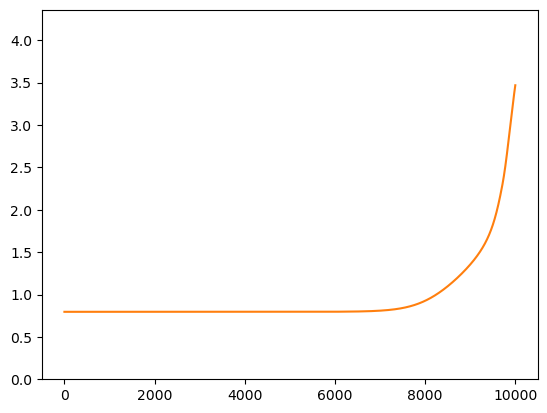

In [41]:
import matplotlib.pyplot as plt 
weights_norms = np.linalg.norm(weights_SGD, axis = 1)
plt.hist(weights_norms, density = True)
#plt.plot(iters, mean_dist_pde, label = 'PDE mean value of r1, Delta: 0.4')

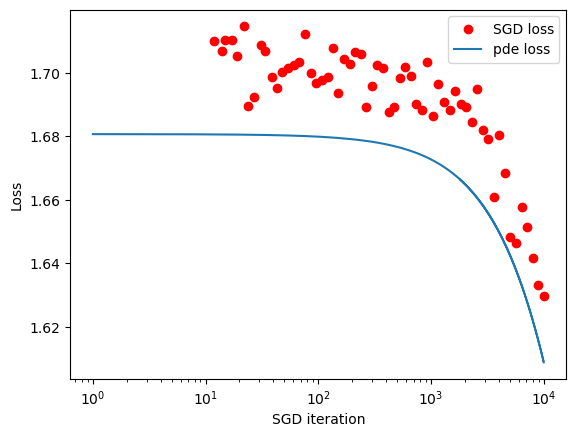

In [160]:
plt.scatter(indices, risk_SGD, label = 'SGD loss', c = 'r')
plt.plot(iters, pde_loss(iters), label = 'pde loss')
plt.ylabel('Loss')
plt.xlabel('SGD iteration')
plt.xscale('log')
plt.legend()

## General Observations

- Managed to implement the PDE in python after optimizing the code (vectorizing, parallelizing) and similar distributions of network parameters in the asymptotic/distributional dynamics (corresponding to 10^7 SGD iterations) and discretised particle system corresponding to SGD as claimed in the original paper by Mei et al. (2018)
- Nesterov-accelerated SGD beats plain SGD, as expected, showing an acceleration and faster convergence